# Obtain the datasets from kaggle 
Using KaggleAPI to obtain the [Sentiment Analysis on Movie Review Datasets](https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/data)

In [1]:
!pip install -q kaggle

In [2]:
# upload the Kaggle API Json file to access the datasets
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"zhiyil5","key":"585c5806655d565e36eae6bd814dee41"}'}

[Using Kaggle API on Colab](https://www.kaggle.com/general/74235)

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list


ref                                                 title                                  size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------  ------------------------------------  -----  -------------------  -------------  ---------  ---------------  
ruchi798/data-science-job-salaries                  Data Science Job Salaries               7KB  2022-06-15 08:59:12          17615        549  1.0              
aravindas01/monkeypox-cases-countrywise-data        MonkeyPox Cases_Countrywise Data        6KB  2022-08-10 17:12:36            524         27  0.9117647        
faryarmemon/usa-housing-market-factors              U.S. Housing Market Factors            32KB  2022-08-03 02:19:31            425         30  1.0              
zzettrkalpakbal/full-filled-brain-stroke-dataset    Brain stroke prediction dataset        52KB  2022-07-16 09:57:08           1968         62  0.9705882        
himanshunakrani/student-stud

In [4]:
!kaggle competitions download -c 'sentiment-analysis-on-movie-reviews'

  0% 0.00/1.90M [00:00<?, ?B/s]
100% 1.90M/1.90M [00:00<00:00, 161MB/s]


In [5]:
#unzip the files on Colab
!unzip sentiment-analysis-on-movie-reviews.zip

Archive:  sentiment-analysis-on-movie-reviews.zip
  inflating: sampleSubmission.csv    
  inflating: test.tsv.zip            
  inflating: train.tsv.zip           


In [6]:
!unzip train.tsv.zip
!unzip test.tsv.zip

Archive:  train.tsv.zip
  inflating: train.tsv               
Archive:  test.tsv.zip
  inflating: test.tsv                


# Prepare Data
Load the data into Pandas Dataframes

In [7]:
import pandas as pd

df = pd.read_csv("train.tsv", sep="\t")
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


Check the distribution of the sentiment classes to see if there are any class imbalancces

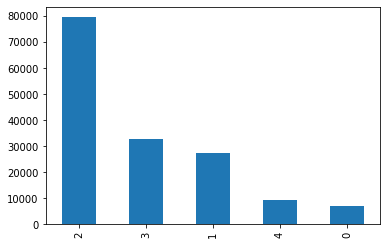

In [8]:
df["Sentiment"].value_counts().plot(kind="bar")

For BERT, we need to tokenize the text to create two input tensors, the input IDs, and attention mask <br>

The dimensions will be len(df) * 512 because 512 is the sequence length of the tokenized sequences for BERT, and len(df) means the count of the samples from the training

In [9]:
import numpy as np

seq_len = 512
num_samples = len(df)

Tokenize with BertTokenizer

In [10]:
!pip install transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 29.7 MB/s 
     |████████████████████████████████| 101 kB 11.6 MB/s 
     |████████████████████████████████| 596 kB 35.6 MB/s 
     |████████████████████████████████| 6.6 MB 50.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [11]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

The token will return three numpy arrays - input_ids, token_type_ids, and attention_mask

In [12]:
tokens = tokenizer(df['Phrase'].tolist(), max_length=seq_len, truncation=True,
                   padding='max_length', add_special_tokens=True,
                   return_tensors='np')

In [13]:
tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

Save the file as Numpy binary files, this is for persisteing a single arbitrary NumPy array on disk. The format stores all of the shape and dtype information necessary to reconstruct the array correctly even on another machine with a different architecture. The format is designed to be as simple as possible while achieving its limited goals.[reference](https://numpy.org/devdocs/reference/generated/numpy.lib.format.html)

In [14]:
with open('movie-xids.npy', 'wb') as f:
    np.save(f, tokens['input_ids'])
with open('movie-xmask.npy', 'wb') as f:
    np.save(f, tokens['attention_mask'])

We also need to extrac the values and use one-hot encode the labels to another numpy array so that it would be len(df) * 5 label classes. 

In [15]:
arr = df["Sentiment"].values
#initialize the zero array
labels = np.zeros((num_samples, arr.max()+1))

Use the curent values in the arr [0, 1, 2, 3, 4] to place 1 values in the right positions

In [16]:
labels[np.arange(num_samples), arr] = 1
labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [17]:
with open("movie-labels.npy", "wb") as f:
  np.save(f, labels)

# Input Pipeline
Use TensorFlow to make use of the tf.data.Dataset object [TensorFlow Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)

In [18]:
with open('movie-xids.npy', 'rb') as f:
    Xids = np.load(f, allow_pickle=True)
with open('movie-xmask.npy', 'rb') as f:
    Xmask = np.load(f, allow_pickle=True)
with open('movie-labels.npy', 'rb') as f:
    labels = np.load(f, allow_pickle=True)

In [19]:
import tensorflow as tf

dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

dataset.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(512,), dtype=tf.int64, name=None), TensorSpec(shape=(512,), dtype=tf.int64, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

Then, each sample of the dataset would containing Xids, Xmask, and labels tensor. 

In [20]:
def map_func(input_ids, masks, labels):
    # we convert our three-item tuple into a two-item tuple where the input item is a dictionary
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

#use the dataset map method to apply this transformation
dataset = dataset.map(map_func)

dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(512,), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(512,), dtype=tf.int64, name=None)}, TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

Use batch size of 16 and drrop any samples that don't fit into chunks of 16

In [21]:
batch_size = 16

dataset = dataset.shuffle(10000).batch(batch_size, drop_remainder=True)

dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)}, TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))>

Split the data into training and validation by 90-10 split

In [22]:
split = 0.9

# calculate how many be taken to the training set
size = int((Xids.shape[0] / batch_size) * split)

size

8778

In [23]:
train_ds = dataset.take(size)
val_ds = dataset.skip(size)

Save the files by using tf.data.experimental.save. When loading the files, element_spec which describes the tensor shape should be specified

In [24]:
tf.data.experimental.save(train_ds, 'train')
tf.data.experimental.save(val_ds, 'val')

In [25]:
train_ds.element_spec

({'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None),
  'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)},
 TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))

# Build and train

In [26]:
from transformers import TFAutoModel

bert = TFAutoModel.from_pretrained('bert-base-cased')
bert.summary()

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


To define the frame around BERT, we need two input layers(one for input IDs and one for attention mask, a post-bert dropout layer to reduce the likelihood of overfitting and improve generalizaton, max pooling layer to convert the 3D tensors output by Bert to 2D and finally softmax as output activation for categorical probabilities

In [27]:
input_ids = tf.keras.layers.Input(shape=(512,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(512,), name='attention_mask', dtype='int32')

In [28]:
embeddings = bert.bert(input_ids, attention_mask=mask)[1]
x = tf.keras.layers.Dense(1024, activation='relu')(embeddings)
y = tf.keras.layers.Dense(5, activation='softmax', name='outputs')(x)

In [29]:
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

BERT is already a pre-trained model that is highly trained and has lots of parameters that take a long time to train further. We could just use the parameters from Bert for the task. 

In [35]:
#freeze bert layer, optional
model.layers[2].trainable = False

In [36]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

In [37]:
optimizer = tf.keras.optimizers.Adam(lr=1e-5, decay=1e-6)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Load in the training and validation datasets and specify the element specs

In [38]:
element_spec = ({'input_ids': tf.TensorSpec(shape=(16, 512), dtype=tf.int64, name=None),
                 'attention_mask': tf.TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)},
                tf.TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))

# load the training and validation sets
train_ds = tf.data.experimental.load('train', element_spec=element_spec)
val_ds = tf.data.experimental.load('val', element_spec=element_spec)

# view the input format
train_ds.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)}, TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))>

In [39]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3
)

Epoch 1/3
8778/8778 [==============================] - 7199s 819ms/step - loss: 1.1577 - accuracy: 0.5383 - val_loss: 1.1420 - val_accuracy: 0.5208
Epoch 2/3
8778/8778 [==============================] - 7155s 815ms/step - loss: 1.0935 - accuracy: 0.5596 - val_loss: 1.0990 - val_accuracy: 0.5362
Epoch 3/3
8778/8778 [==============================] - 7184s 818ms/step - loss: 1.0659 - accuracy: 0.5693 - val_loss: 1.0809 - val_accuracy: 0.5412


In [40]:
#save the model for future usage
model.save("sentiment_model")

# Load and predict

In [41]:
model = tf.keras.models.load_model('sentiment_model')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

For the predictions, we need to format the data: tokenizing by using bert-base-cased and transform the data into dictionary that has "input_ids" and "attention_mask" tensors. 

In [42]:
def prep_data(text):
    tokens = tokenizer.encode_plus(text, max_length=512,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_token_type_ids=False,
                                   return_tensors='tf')
    # tokenizer returns int32 tensors, we need to return int64, so we use tf.cast
    return {'input_ids': tf.cast(tokens['input_ids'], tf.int64),
            'attention_mask': tf.cast(tokens['attention_mask'], tf.int64)}

In [43]:
df = pd.read_csv("test.tsv", sep="\t")
df.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [44]:
df['Sentiment'] = None

for i, row in df.iterrows():
    # get token tensors
    tokens = prep_data(row['Phrase'])
    # get probabilities
    probs = model.predict(tokens)
    # find argmax for winning class
    pred = np.argmax(probs)
    # add to dataframe
    df.at[i, 'Sentiment'] = pred

df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,156061,8545,An intermittently pleasing but mostly routine ...,2
1,156062,8545,An intermittently pleasing but mostly routine ...,2
2,156063,8545,An,2
3,156064,8545,intermittently pleasing but mostly routine effort,2
4,156065,8545,intermittently pleasing but mostly routine,2


In [45]:
df.tail

<bound method NDFrame.tail of        PhraseId  SentenceId  \
0        156061        8545   
1        156062        8545   
2        156063        8545   
3        156064        8545   
4        156065        8545   
...         ...         ...   
66287    222348       11855   
66288    222349       11855   
66289    222350       11855   
66290    222351       11855   
66291    222352       11855   

                                                  Phrase Sentiment  
0      An intermittently pleasing but mostly routine ...         2  
1      An intermittently pleasing but mostly routine ...         2  
2                                                     An         2  
3      intermittently pleasing but mostly routine effort         2  
4             intermittently pleasing but mostly routine         2  
...                                                  ...       ...  
66287             A long-winded , predictable scenario .         2  
66288               A long-winded , predictab